In [152]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from TCN_jordan import *
from hampel import hampel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
data_set = pd.read_csv(r'Dataset/exchange_rate.csv')

In [191]:
def calculate_nan_percentage(dataframe):
    # Count the number of NaN values in each column
    nan_counts = dataframe.isna().sum()

    # Calculate the percentage of NaN values in each column
    nan_percentage = (nan_counts / len(dataframe)) * 100

    return nan_percentage
calculate_nan_percentage(data_set)

Australia      0.0
 British       0.0
 Canada        0.0
China          0.0
Japan          0.0
New Zealand    0.0
 Singapore     0.0
Switzerland    0.0
dtype: float64

In [ ]:
nan_dataset=calculate_nan_percentage(data_set)

# data_set=data_set.drop(columns='NMHC(GT)')
data_set=data_set.drop(columns=list(nan_dataset[nan_dataset>40].index),axis=1) 
data_set= data_set.fillna(data_set.median())

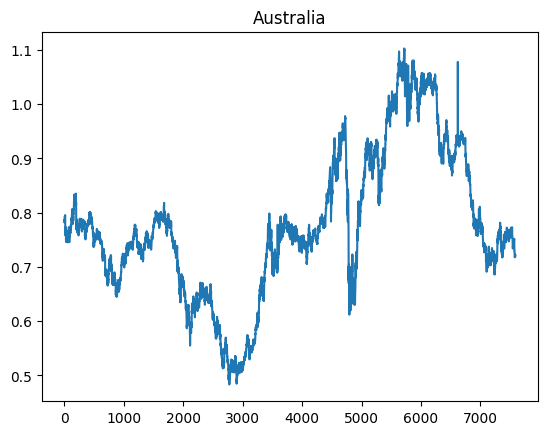

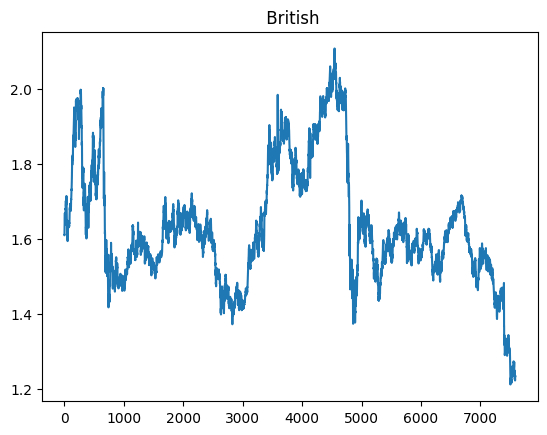

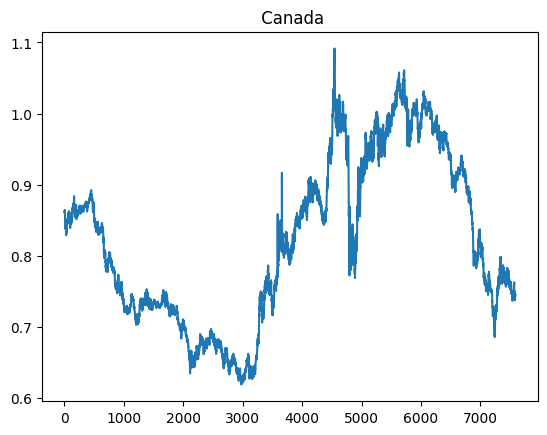

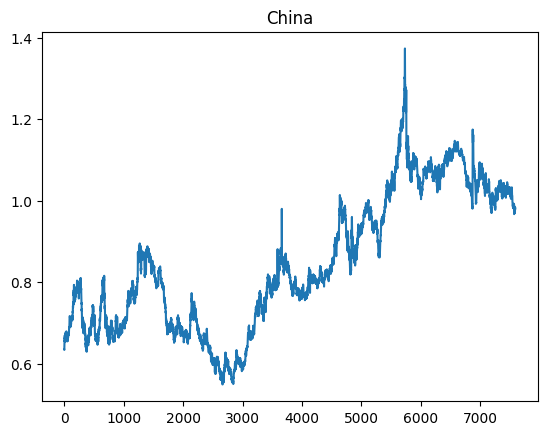

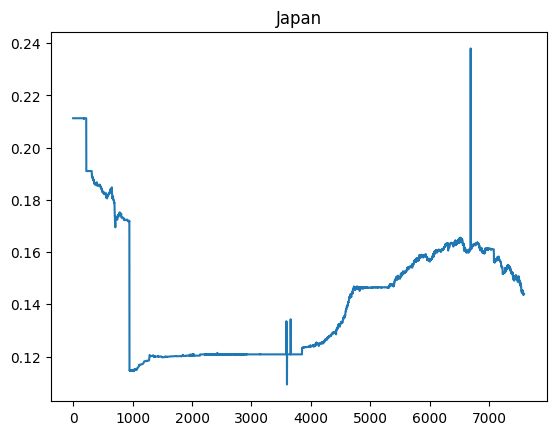

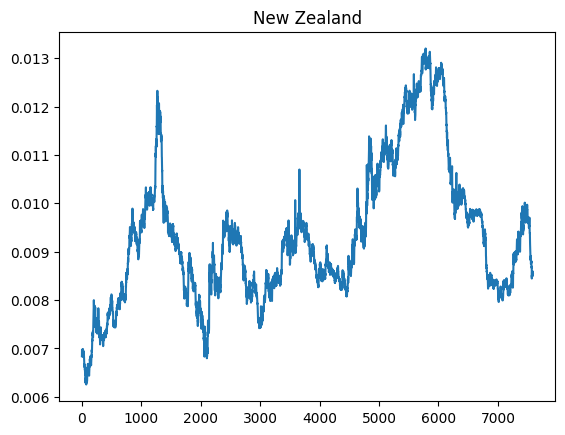

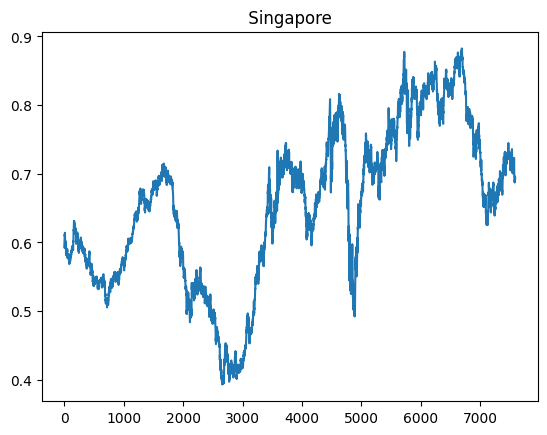

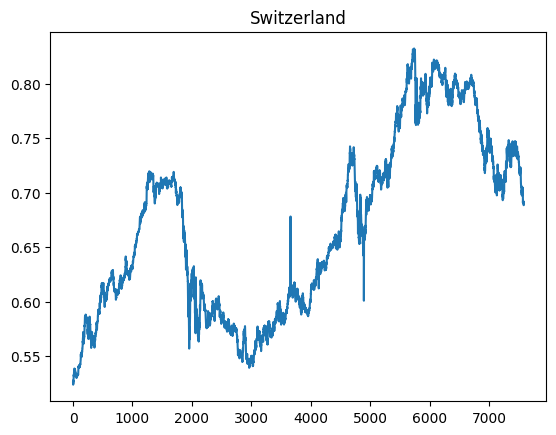

In [192]:
for col in data_set.columns:
        data_set[col].plot()#marker='.', linestyle='', markersize=10)
        plt.title(col)
        plt.show()

In [193]:
data_set=data_set.drop(columns='Japan')

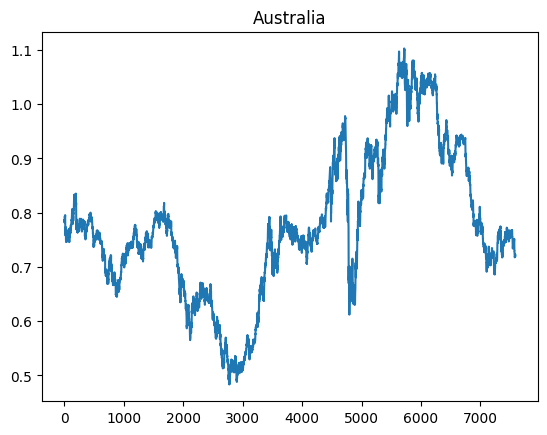

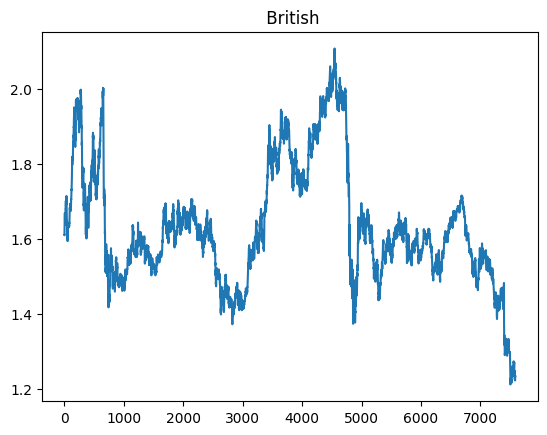

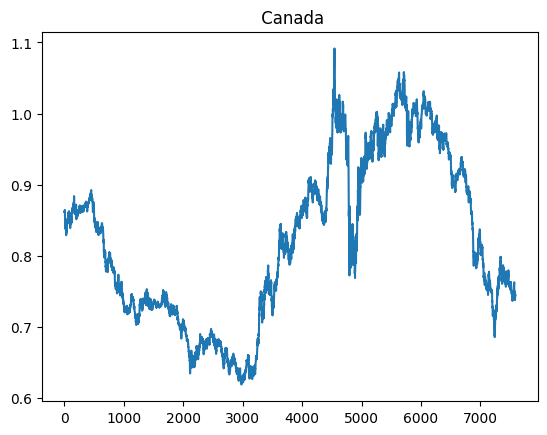

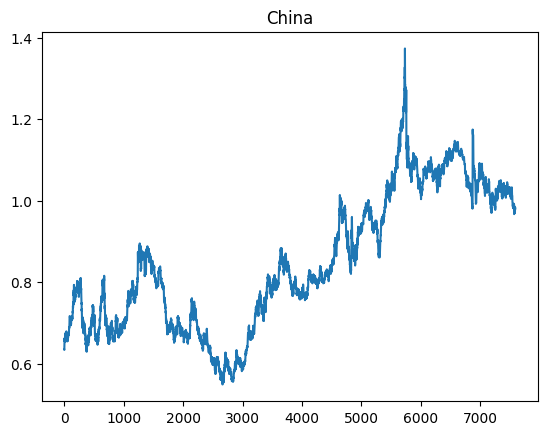

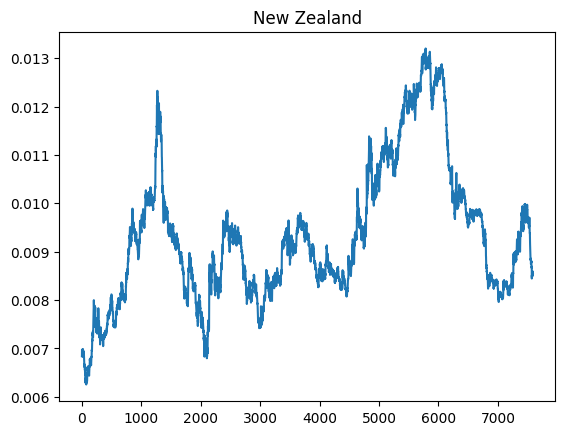

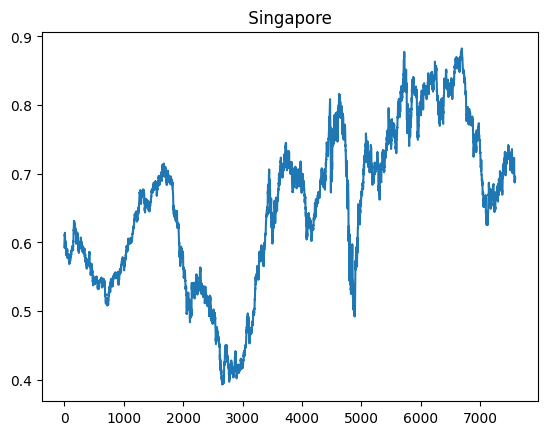

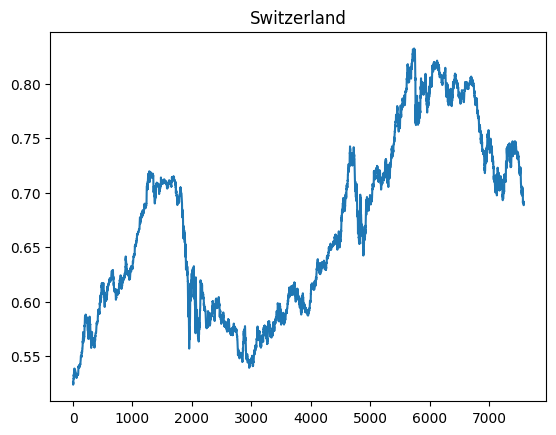

In [195]:
for col in data_set.columns:
    data_set[col]=hampel(data_set[col],window_size=10).filtered_data
    data_set[col].plot()
    plt.title(col)
    plt.show()

In [196]:
data_set= data_set.ewm(alpha=0.02, adjust=False).mean()

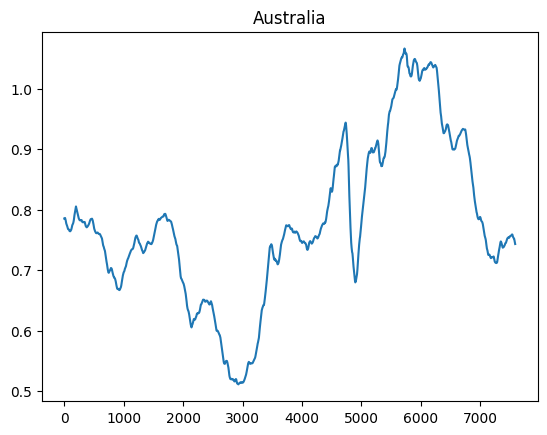

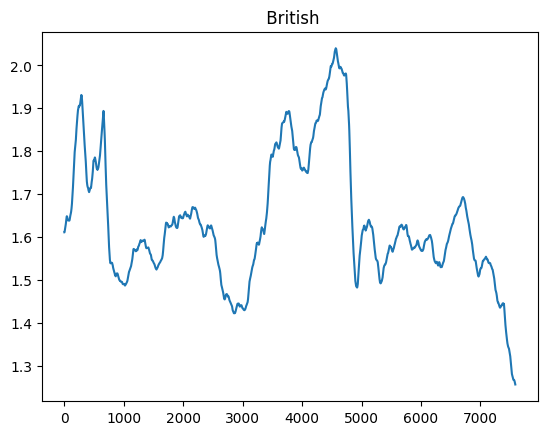

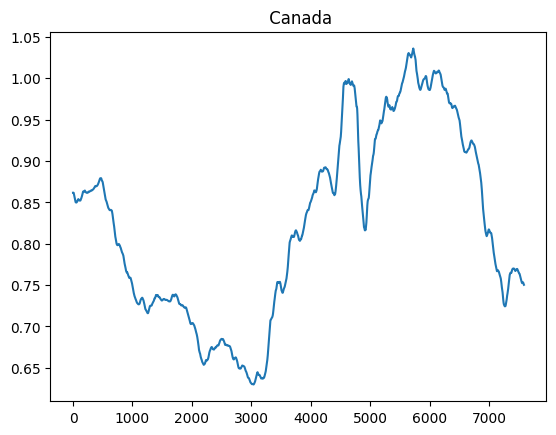

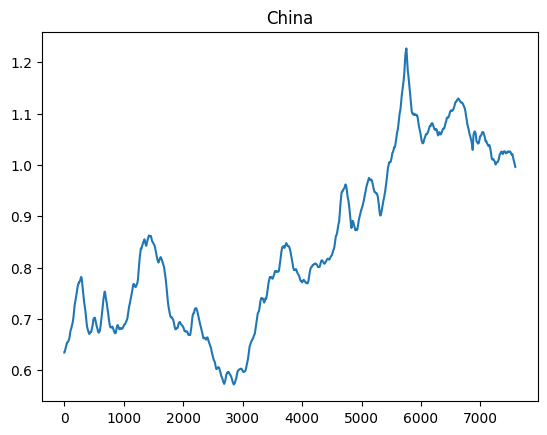

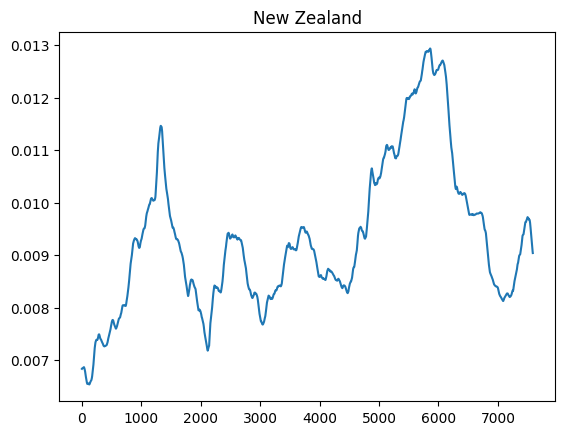

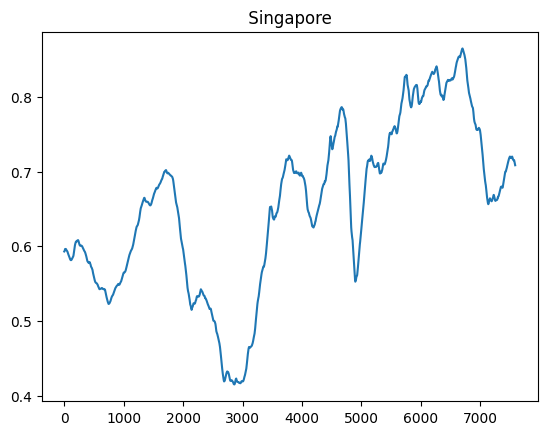

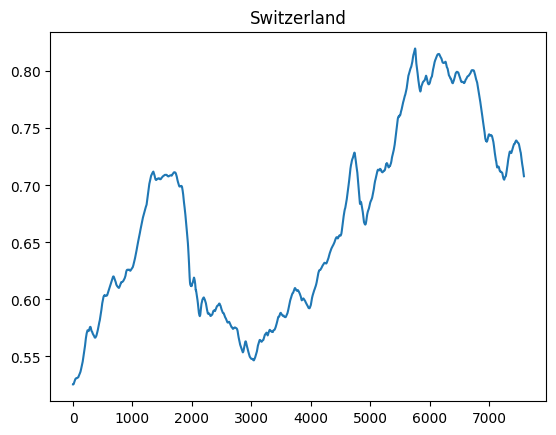

In [197]:
for col in data_set.columns:
    data_set[col].plot()
    plt.title(col)
    plt.show()

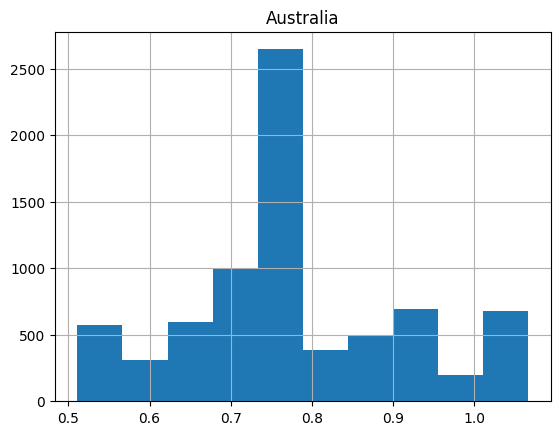

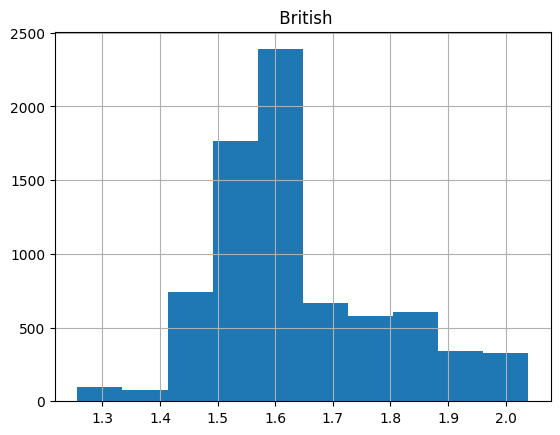

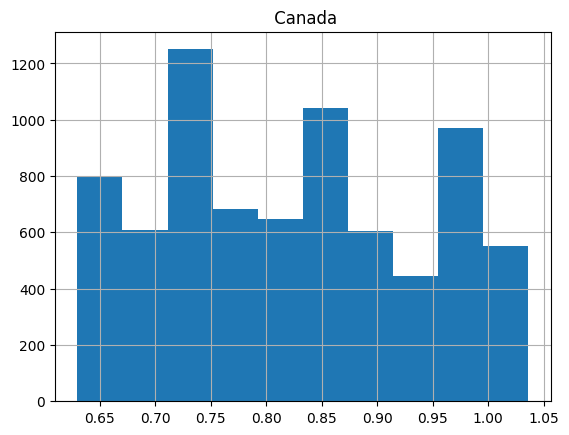

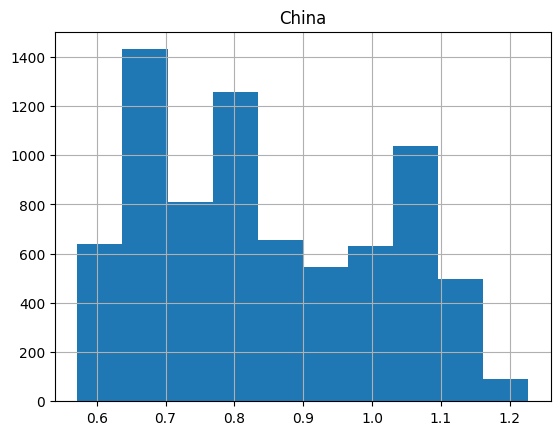

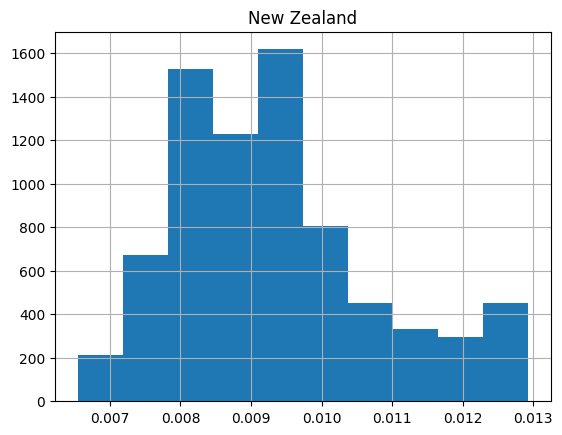

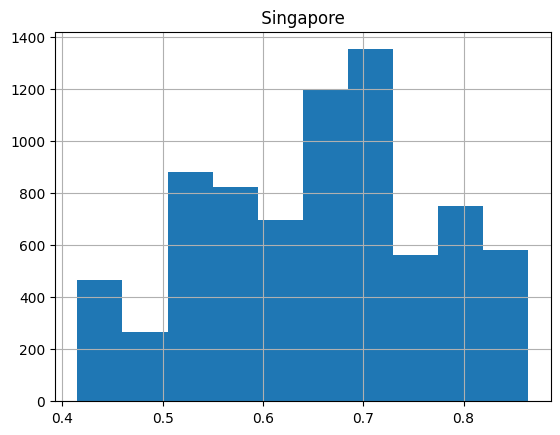

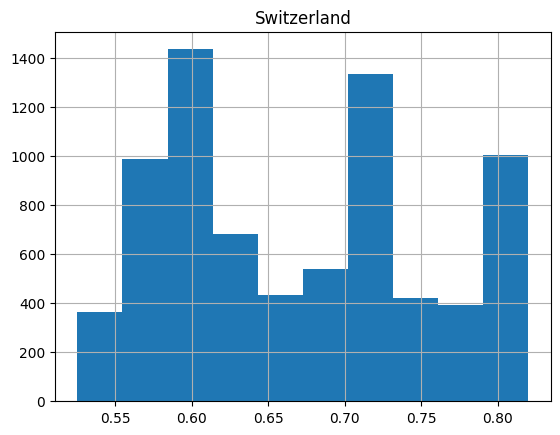

In [198]:
for col in data_set.columns:
        data_set[col].hist()
        plt.title(col)
        plt.show()

In [199]:
# standard scale the data
data_set=(data_set-data_set.mean())/data_set.std()

In [200]:
# data_set = pd.read_csv(r'Dataset/exchange_rate.csv')
train_val_data = data_set[: int(0.95 * len(data_set))]

validation_data = train_val_data[int(0.8 * len(train_val_data)):].copy()
train_data = train_val_data[: int(0.8 * len(train_val_data))]

test_data = data_set[int(0.95 * len(data_set)):]

In [204]:
def objective(trial):

    try:

        # Instantiate your ElectricNet model with the sampled hyperparameters
        window_size = trial.suggest_int('window_size', 10, 30)
        kernel_size = 2*trial.suggest_int('kernel_size', 3, 5)+1
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 3, 10)
        n_hidden_dimensions = trial.suggest_int('n_hidden_dimensions', 1, 10)
        
        # n_signals = trial.suggest_int('n_signals', 1, 10)
        prediction_horizon = 2 #trial.suggest_int('prediction_horizon', 1, 2)
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        batch_size = trial.suggest_int('batch_size', 64, 128)
        
        patience = 50 #trial.suggest_int('patience', 10, 30)
        conv_dilatation = trial.suggest_int('conv_dilatation', 1, 3)
        n_signals=7
        
        # TODO : - Conv dilation il l'a enforcé à 1 - kernel size est obligé d'être impair à cause de comment il set le padding - les index à prendre ca doit etre dim_points_df-prediction_horizon+1 - revoir la relation windows size et training - check l'architecture
        
        
        nb_epochs = 200#
        
        seed= trial.suggest_int('seed', 50, 200)
        number_TCN= trial.suggest_int('number_TCN', 3, 7)
        # Create an instance of the PSTA_TCN model with the sampled hyperparameters
        model = PSTA_TCN(
            window_size=window_size,
            kernel_size=kernel_size,
            n_hidden_layers=n_hidden_layers,
            n_hidden_dimensions=n_hidden_dimensions,
            n_signals=n_signals,
            prediction_horizon=prediction_horizon,
            lr=lr,
            dropout_rate=dropout_rate,
            batch_size=batch_size,
            nb_epochs=nb_epochs,
            patience=patience,
            conv_dilatation=conv_dilatation,
            seed=seed,
            number_TCN=number_TCN,
            
        )

        model.fit(train_data, validation_data)

        points=predict_fn(model,data_set)
        df_points=pd.DataFrame(points.detach().numpy())
        df_points[0]=df_points[0].astype('int')
        df_points= df_points.groupby(0).mean()
        
        plt.scatter(x=points[:,0],y=points[:,1],label='predicted_points')
        data_set.iloc[:,0].plot(label='real_curve',color='red')
        plt.title('prediction_'+str(model.seed))
        plt.legend()
        plt.show()
        
        return -np.corrcoef(data_set.iloc[df_points.index-prediction_horizon+1,0].values.flatten(),df_points.values.flatten())[0,1]



    except Exception as e:
        raise optuna.exceptions.TrialPruned(f'Skipping this trial due to an error: {str(e)}')
    


[I 2023-12-18 22:04:59,950] Trial 3 pruned. Skipping this trial due to an error: Socket operation on non-socket
--- Logging error ---
Traceback (most recent call last):
  File "/Users/jordan/opt/anaconda3/lib/python3.9/logging/__init__.py", line 1086, in emit
    stream.write(msg + self.terminator)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/ipykernel/iostream.py", line 648, in write
    self._schedule_flush()
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/ipykernel/iostream.py", line 545, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/ipykernel/iostream.py", line 251, in schedule
    self._event_pipe.send(b"")
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/zmq/sugar/socket.py", line 618, in send
    return super().send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/socket.pyx", line 740, in zmq.backend.cython.socket.Socket.s

In [205]:
def run_optuna():

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50,n_jobs=3)
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")

    study.trials_dataframe().to_excel(r'/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/result_summary.xlsx')
    fig = optuna.visualization.plot_param_importances(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_params.png", format='png', engine='kaleido')
    fig = optuna.visualization.plot_optimization_history(study)
    fig.write_image(r"/Users/jordan/Documents/MVA/ML_TS_2023/Projet/optuna_analysis/fig_history.png", format='png', engine='kaleido')


    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    best_num=list(study.trials_dataframe().sort_values(by='value', ascending=False)[:5]['number'])
    print(best_num)


[I 2023-12-18 22:05:32,390] A new study created in memory with name: no-name-47434d85-eb85-48a1-9235-8cc7c8626c02
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



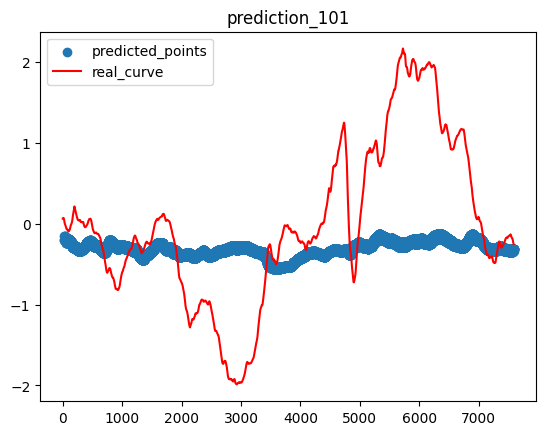

[I 2023-12-18 22:10:04,314] Trial 4 finished with value: -0.4663634109231476 and parameters: {'window_size': 28, 'kernel_size': 4, 'n_hidden_layers': 8, 'n_hidden_dimensions': 6, 'lr': 0.00012839901504646236, 'dropout_rate': 0.41558427046238877, 'batch_size': 115, 'conv_dilatation': 3, 'seed': 101, 'number_TCN': 3}. Best is trial 0 with value: -0.5146544706598973.


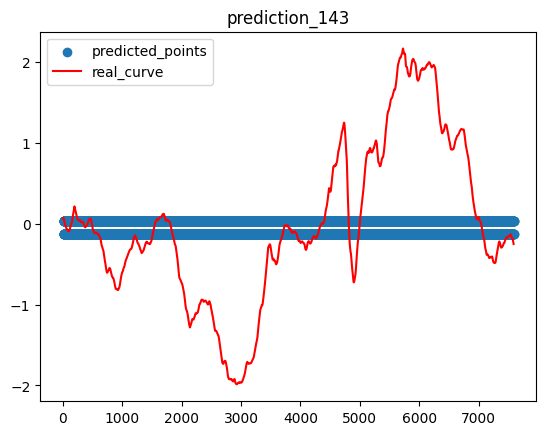

[I 2023-12-18 22:11:19,815] Trial 0 finished with value: 0.0025721100319617564 and parameters: {'window_size': 16, 'kernel_size': 5, 'n_hidden_layers': 10, 'n_hidden_dimensions': 7, 'lr': 5.121819949904081e-05, 'dropout_rate': 0.16398042774880073, 'batch_size': 101, 'conv_dilatation': 1, 'seed': 143, 'number_TCN': 3}. Best is trial 0 with value: 0.0025721100319617564.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



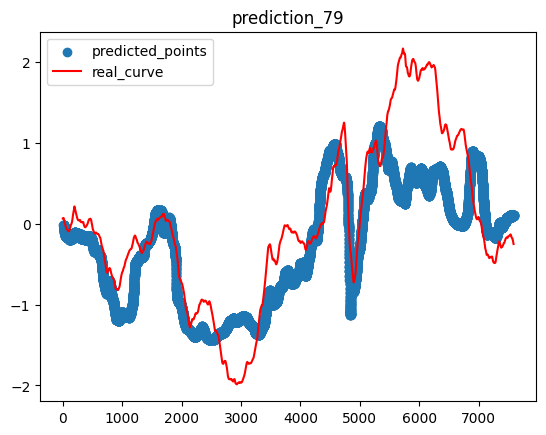

[I 2023-12-18 22:11:32,853] Trial 5 finished with value: -0.8286705679753769 and parameters: {'window_size': 12, 'kernel_size': 5, 'n_hidden_layers': 9, 'n_hidden_dimensions': 4, 'lr': 0.0006441075637731088, 'dropout_rate': 0.1652563195295617, 'batch_size': 102, 'conv_dilatation': 3, 'seed': 79, 'number_TCN': 7}. Best is trial 5 with value: -0.8286705679753769.


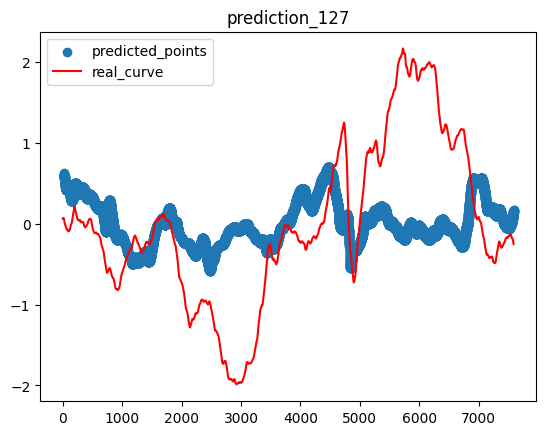

[I 2023-12-18 22:12:06,053] Trial 1 finished with value: -0.1759333870283216 and parameters: {'window_size': 22, 'kernel_size': 5, 'n_hidden_layers': 10, 'n_hidden_dimensions': 6, 'lr': 0.00043020670878190977, 'dropout_rate': 0.28706823619357397, 'batch_size': 115, 'conv_dilatation': 2, 'seed': 127, 'number_TCN': 4}. Best is trial 1 with value: -0.1759333870283216.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



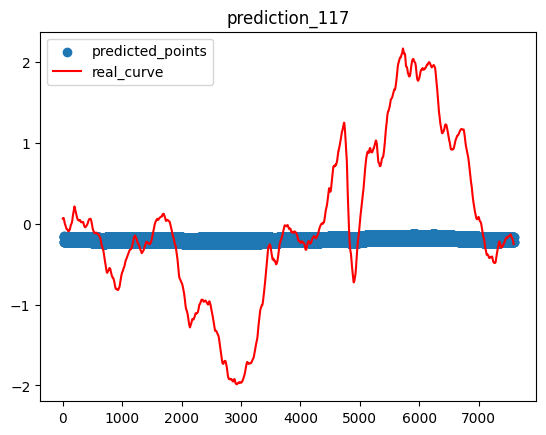

[I 2023-12-18 22:14:01,713] Trial 2 finished with value: -0.9295091774760149 and parameters: {'window_size': 25, 'kernel_size': 3, 'n_hidden_layers': 9, 'n_hidden_dimensions': 6, 'lr': 1.954465689016312e-05, 'dropout_rate': 0.343840787003485, 'batch_size': 69, 'conv_dilatation': 1, 'seed': 117, 'number_TCN': 6}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



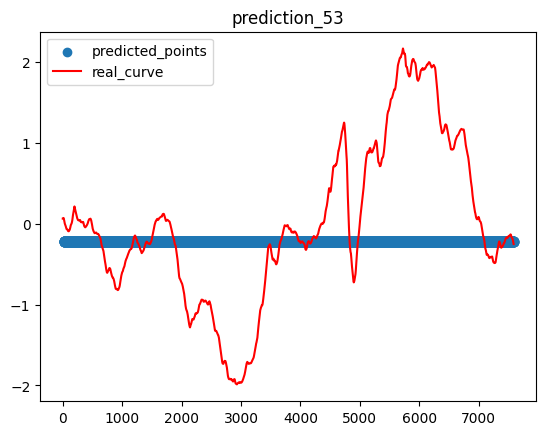

[I 2023-12-18 22:17:10,669] Trial 5 finished with value: -0.0023923092367035127 and parameters: {'window_size': 24, 'kernel_size': 3, 'n_hidden_layers': 8, 'n_hidden_dimensions': 8, 'lr': 0.0001717766342342721, 'dropout_rate': 0.22924719929878817, 'batch_size': 114, 'conv_dilatation': 1, 'seed': 53, 'number_TCN': 3}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



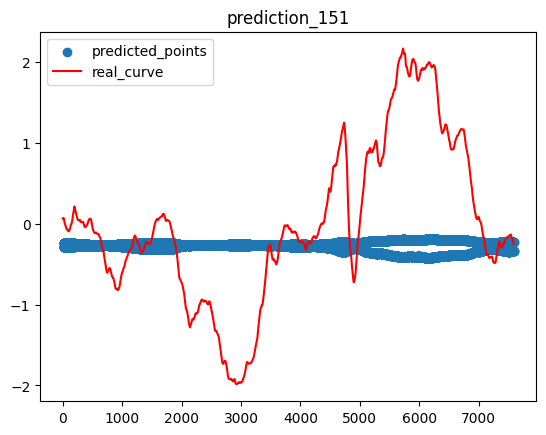

[I 2023-12-18 22:18:23,537] Trial 4 finished with value: 0.8961059522722694 and parameters: {'window_size': 17, 'kernel_size': 5, 'n_hidden_layers': 5, 'n_hidden_dimensions': 5, 'lr': 2.9575906164020875e-05, 'dropout_rate': 0.1263446740073777, 'batch_size': 88, 'conv_dilatation': 3, 'seed': 151, 'number_TCN': 6}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



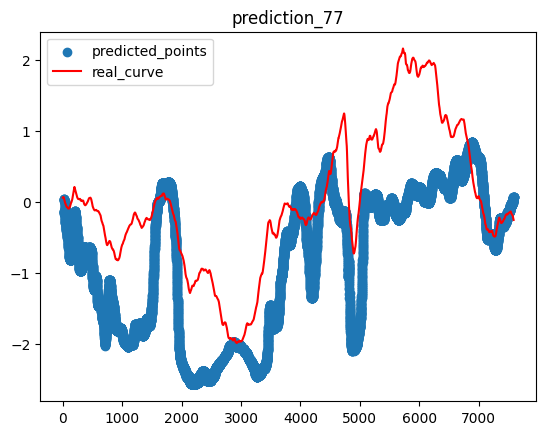

[I 2023-12-18 22:20:55,642] Trial 3 finished with value: -0.7752529300450802 and parameters: {'window_size': 22, 'kernel_size': 4, 'n_hidden_layers': 4, 'n_hidden_dimensions': 7, 'lr': 0.0005356885774616457, 'dropout_rate': 0.4662143999762732, 'batch_size': 73, 'conv_dilatation': 1, 'seed': 77, 'number_TCN': 7}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



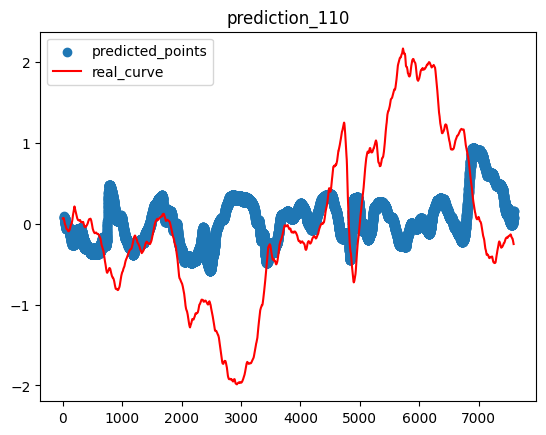

[I 2023-12-18 22:24:55,427] Trial 6 finished with value: 0.007880345873512924 and parameters: {'window_size': 27, 'kernel_size': 5, 'n_hidden_layers': 7, 'n_hidden_dimensions': 5, 'lr': 0.0002275697095225222, 'dropout_rate': 0.10157401519435072, 'batch_size': 96, 'conv_dilatation': 3, 'seed': 110, 'number_TCN': 5}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



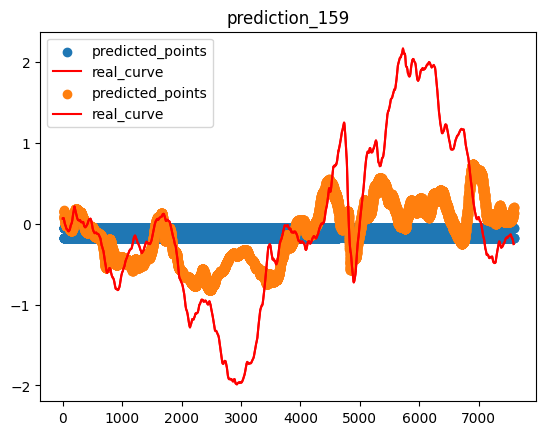

[I 2023-12-18 22:25:18,314] Trial 7 finished with value: 0.03049609231455376 and parameters: {'window_size': 17, 'kernel_size': 5, 'n_hidden_layers': 8, 'n_hidden_dimensions': 1, 'lr': 1.5471423691649454e-05, 'dropout_rate': 0.04318348682138651, 'batch_size': 82, 'conv_dilatation': 1, 'seed': 119, 'number_TCN': 6}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



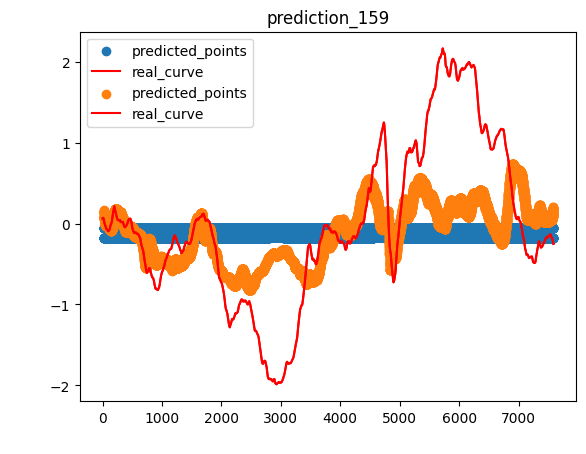

[I 2023-12-18 22:25:18,987] Trial 8 finished with value: -0.6803023203147888 and parameters: {'window_size': 20, 'kernel_size': 5, 'n_hidden_layers': 5, 'n_hidden_dimensions': 8, 'lr': 0.0001624152350907676, 'dropout_rate': 0.3176356044311384, 'batch_size': 125, 'conv_dilatation': 1, 'seed': 159, 'number_TCN': 3}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



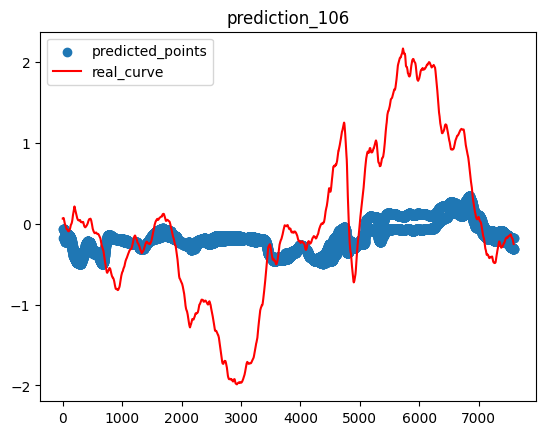

[I 2023-12-18 22:30:42,691] Trial 11 finished with value: -0.5315767483759487 and parameters: {'window_size': 11, 'kernel_size': 5, 'n_hidden_layers': 4, 'n_hidden_dimensions': 5, 'lr': 0.00033980748532437587, 'dropout_rate': 0.07517699404094563, 'batch_size': 124, 'conv_dilatation': 3, 'seed': 106, 'number_TCN': 5}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



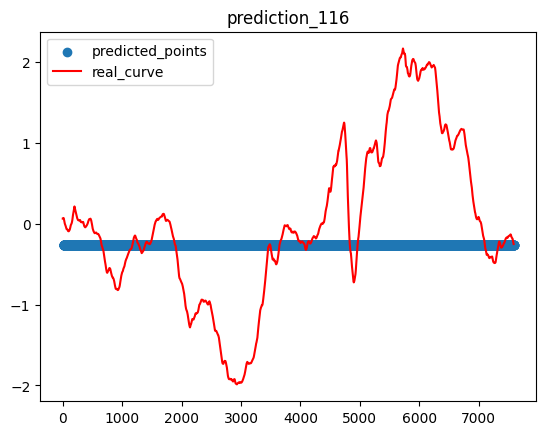

[I 2023-12-18 22:30:57,196] Trial 10 finished with value: 0.0026040924996551394 and parameters: {'window_size': 13, 'kernel_size': 5, 'n_hidden_layers': 3, 'n_hidden_dimensions': 6, 'lr': 0.0005312773015177559, 'dropout_rate': 0.045503619417753716, 'batch_size': 66, 'conv_dilatation': 1, 'seed': 116, 'number_TCN': 5}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



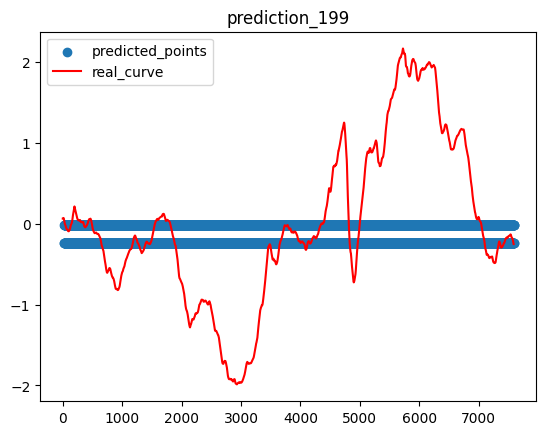

[I 2023-12-18 22:31:18,224] Trial 9 finished with value: 0.0022698308183253433 and parameters: {'window_size': 28, 'kernel_size': 4, 'n_hidden_layers': 3, 'n_hidden_dimensions': 1, 'lr': 1.4087228753128208e-05, 'dropout_rate': 0.38875154659311456, 'batch_size': 77, 'conv_dilatation': 1, 'seed': 199, 'number_TCN': 6}. Best is trial 2 with value: -0.9295091774760149.
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:13: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/189627063.py:14: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

ERROR:root:Internal Python error in the inspect module.
Below is the tra

Traceback (most recent call last):
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 100, in _optimize
    completed, futures = wait(futures, return_when=FIRST_COMPLETED)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/concurrent/futures/_base.py", line 307, in wait
    waiter.event.wait(timeout)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/threading.py", line 581, in wait
    signaled = self._cond.wait(timeout)
  File "/Users/jordan/opt/anaconda3/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jordan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_61804/2758442742.py", line 1, in <module>
    run_optuna()
 

TypeError: object of type 'NoneType' has no len()

In [206]:
run_optuna()

In [18]:
def predict_fn(model,dataset):
        prediction_horizon=model.tau
        window_size=model.T 
        train_set = torch.from_numpy(dataset.astype('float32').values)
        train_data = [train_set[i: i + window_size] for i in range(len(train_set) - window_size)]
        point_to_plot=[]
        for i,x in enumerate(train_data):
                predictions=model.predict(x)
                point_to_plot+=[torch.Tensor([v,predictions.squeeze()[k]]) for k,v in enumerate(np.arange(i+window_size,i+window_size+prediction_horizon))]
        
        point_to_plot=torch.stack(point_to_plot)
        
        return point_to_plot
  

In [138]:
# rams: 
#     window_size: 19
#     kernel_size: 4
#     n_hidden_layers: 10
#     n_hidden_dimensions: 5
#     lr: 0.0002591332973344816
#     dropout_rate: 0.11272903542955753
#     batch_size: 107
#     seed: 151
#     number_TCN: 5
    
model_2= PSTA_TCN(
window_size=19,
kernel_size=9,
n_hidden_layers=10,
n_hidden_dimensions=5,
n_signals=7,
prediction_horizon=2,
batch_size=107,
lr=0.0002591332973344816,
nb_epochs=200,
number_TCN=5,
dropout_rate=0.11272903542955753,
seed=129,
patience=50,
)

model_2.fit(train_data,validation_data)

In [139]:
points=predict_fn(model_2,data_set)

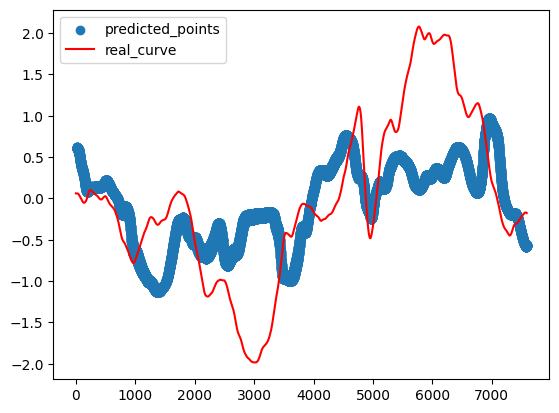

In [140]:
plt.scatter(x=points[:,0],y=points[:,1],label='predicted_points')
data_set.iloc[:,0].plot(label='real_curve',color='red')
plt.legend()

In [141]:
# points=predict_fn(model,data_set,prediction_horizon,window_size=40)

In [142]:
# points=predict_fn(model,data_set,prediction_horizon,window_size=40)
df_points=pd.DataFrame(points.detach().numpy())
df_points[0]=df_points[0].astype('int')
df_points= df_points.groupby(0).mean()
np.linalg.norm(data_set.iloc[df_points.index-1,0].values.flatten()-df_points.values.flatten())

72.07399414504543

In [143]:
np.corrcoef(data_set.iloc[df_points.index-1,0].values.flatten(),df_points.values.flatten())[0,1]

0.571207030200063